In [1]:
from AdaCC import AdaCC
from Competitors.CGAda_Cal import CGAda_Cal
from Competitors.AdaMEC_Cal import AdaMEC_Cal
from Competitors.RareBoost import RareBoost
from Competitors.AdaMEC import AdaMEC
import warnings
warnings.filterwarnings("ignore")

from Competitors.CostBoostingAlgorithms import CostSensitiveAlgorithms
from collections import defaultdict, Counter
import operator, os, pickle
from multiprocessing import Process
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
sns.set_style('white')
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
# X, y = make_moons(n_samples=150, noise=7/ 10., random_state=10)      


def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = None , ax = None, flag=False, second=False ):
    if scatter_weights is None:
         scatter_weights = np.ones(len(y))
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )

#     #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        #         if flag and not second:
#             zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
#         elif flag and second:
#             zz = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
            
#         elif not flag:
#             zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        
            #         print("decision_function")
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    
    
    if not flag:
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )

        #         print("predict_proba")
#     else :
#         print("none")

#         zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.7,levels=[0,0.5,1])
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
#     ax.set_xlabel('$X_1$')
#     ax.set_ylabel('$X_2$')

In [3]:
def AdaCC_scratch(X,y, M, method):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]
  
    adacc = AdaCC(n_estimators=M, algorithm=method)
    adacc.fit(X, y)

    #Save iteration values
    estimator_list = adacc.estimator_tmp
    estimator_weight_list = adacc.alpha_tmp
    sample_weight_list = adacc.smp_w_tmp
        


    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)
     
    return estimator_list, estimator_weight_list, sample_weight_list, adacc


In [4]:
def competitors(X,y, M, method):
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]
    
    def train_model(X_train,y_train, base_learners, method):
        
        def train_competitors(X_train, y_train, base_learners, method, maj, min, ratio):
            try:
                out = []
                if method == 'CGAda_Cal':
                    clf = CGAda_Cal(n_estimators=base_learners, algorithm=method, class_weight={min: 1, maj: ratio / 10.})
                else:
                    clf = CostSensitiveAlgorithms(n_estimators=base_learners, algorithm=method,
                                                  class_weight={min: 1, maj: ratio / 10.})

                clf.fit(X_train, y_train)

                out.append(f1_score(y_train, clf.predict(X_train)))
                out.append(clf)
                with open('temp_preds/' + method + str(ratio), 'wb') as filehandle:
                    pickle.dump(out, filehandle)
            except:
                return

        
        
        if 'AdaMEC_Cal' in method:
            counter_dict = Counter(list(y_train))
            majority = max(counter_dict.items(), key=operator.itemgetter(1))[0]
            minority = max(counter_dict.items(), key=operator.itemgetter(0))[0]
            ratios = [1., 2., 3., 4., 5., 6., 7, 8., 9., 10.]
            clf = AdaMEC_Cal(n_estimators=base_learners, algorithm=method)
            clf.fit(X_train, y_train)
            best_score = -1
            best_idx = 0
            for idx, cost in enumerate(ratios):
                class_weight = {minority: 1, majority: cost / 10.}
                clf.set_costs(y_train, class_weight)
                score = f1_score(y_train, clf.predict(X_train))
                if best_score < score:
                    best_idx = idx
                    best_score = score
            class_weight = {minority: 1, majority: ratios[best_idx] / 10.}
            clf.set_costs(y_train, class_weight)


        elif 'AdaMEC' in method:
            counter_dict = Counter(list(y_train))
            majority = max(counter_dict.items(), key=operator.itemgetter(1))[0]
            minority = max(counter_dict.items(), key=operator.itemgetter(0))[0]
            ratios = [1., 2., 3., 4., 5., 6., 7, 8., 9., 10.]
            clf = AdaMEC(n_estimators=base_learners, algorithm=method)
            clf.fit(X_train, y_train)
            best_score = -1
            best_idx = 0
            for idx, cost in enumerate(ratios):
                class_weight = {minority: 1, majority: cost / 10.}
                clf.set_costs(class_weight)
                score = f1_score(y_train, clf.predict(X_train))
                if best_score < score:
                    best_idx = idx
                    best_score = score
            class_weight = {minority: 1, majority: ratios[best_idx] / 10.}
            clf.set_costs(class_weight)

        elif method == 'RareBoost':
            clf = RareBoost(n_estimators=base_learners)
            clf.fit(X_train, y_train)
        else:
            counter_dict = Counter(list(y_train))
            majority = max(counter_dict.items(), key=operator.itemgetter(1))[0]
            minority = max(counter_dict.items(), key=operator.itemgetter(0))[0]
            ratios = [1., 2., 3., 4., 5., 6., 7, 8., 9., 10.]
            for ratio in ratios:
                train_competitors(X_train, y_train,   base_learners, method, majority, minority, ratio)
                
            best_score = -1
            best_ratio = 0
            for ratio in ratios:
                if os.path.exists('temp_preds/' + method + str(ratio)):
                    with open('temp_preds/' + method + str(ratio), 'rb') as filehandle:
                        temp = pickle.load(filehandle)
                        if temp[0] > best_score:
                            best_ratio = ratio
                            best_score = temp[0]
                            clf = temp[1]

#                 if os.path.exists('temp_preds/' + method + str(ratio)):
#                     os.remove('temp_preds/' + method + str(ratio))

        return clf
    
    
    clf = train_model(X,y, M, method)
    
    if method == "CGAda_Cal" or  method == "AdaMEC" or  method == "AdaMEC_Cal":
        return _,_,clf
    estimator_list = clf.estimator_tmp
    sample_weight_list = clf.smp_w_tmp
    
    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    sample_weight_list = np.asarray(sample_weight_list)
     
    return estimator_list, sample_weight_list, clf

In [5]:
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / float(N)
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        
    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    return estimator_list, estimator_weight_list, sample_weight_list



415
AdaBoost
AdaCC1
AdaCC2
AdaMEC
AdaMEC_Cal
CGAda
CGAda_Cal
AdaCost
CSB1
CSB2
AdaC1
AdaC2
AdaC3
RareBoost


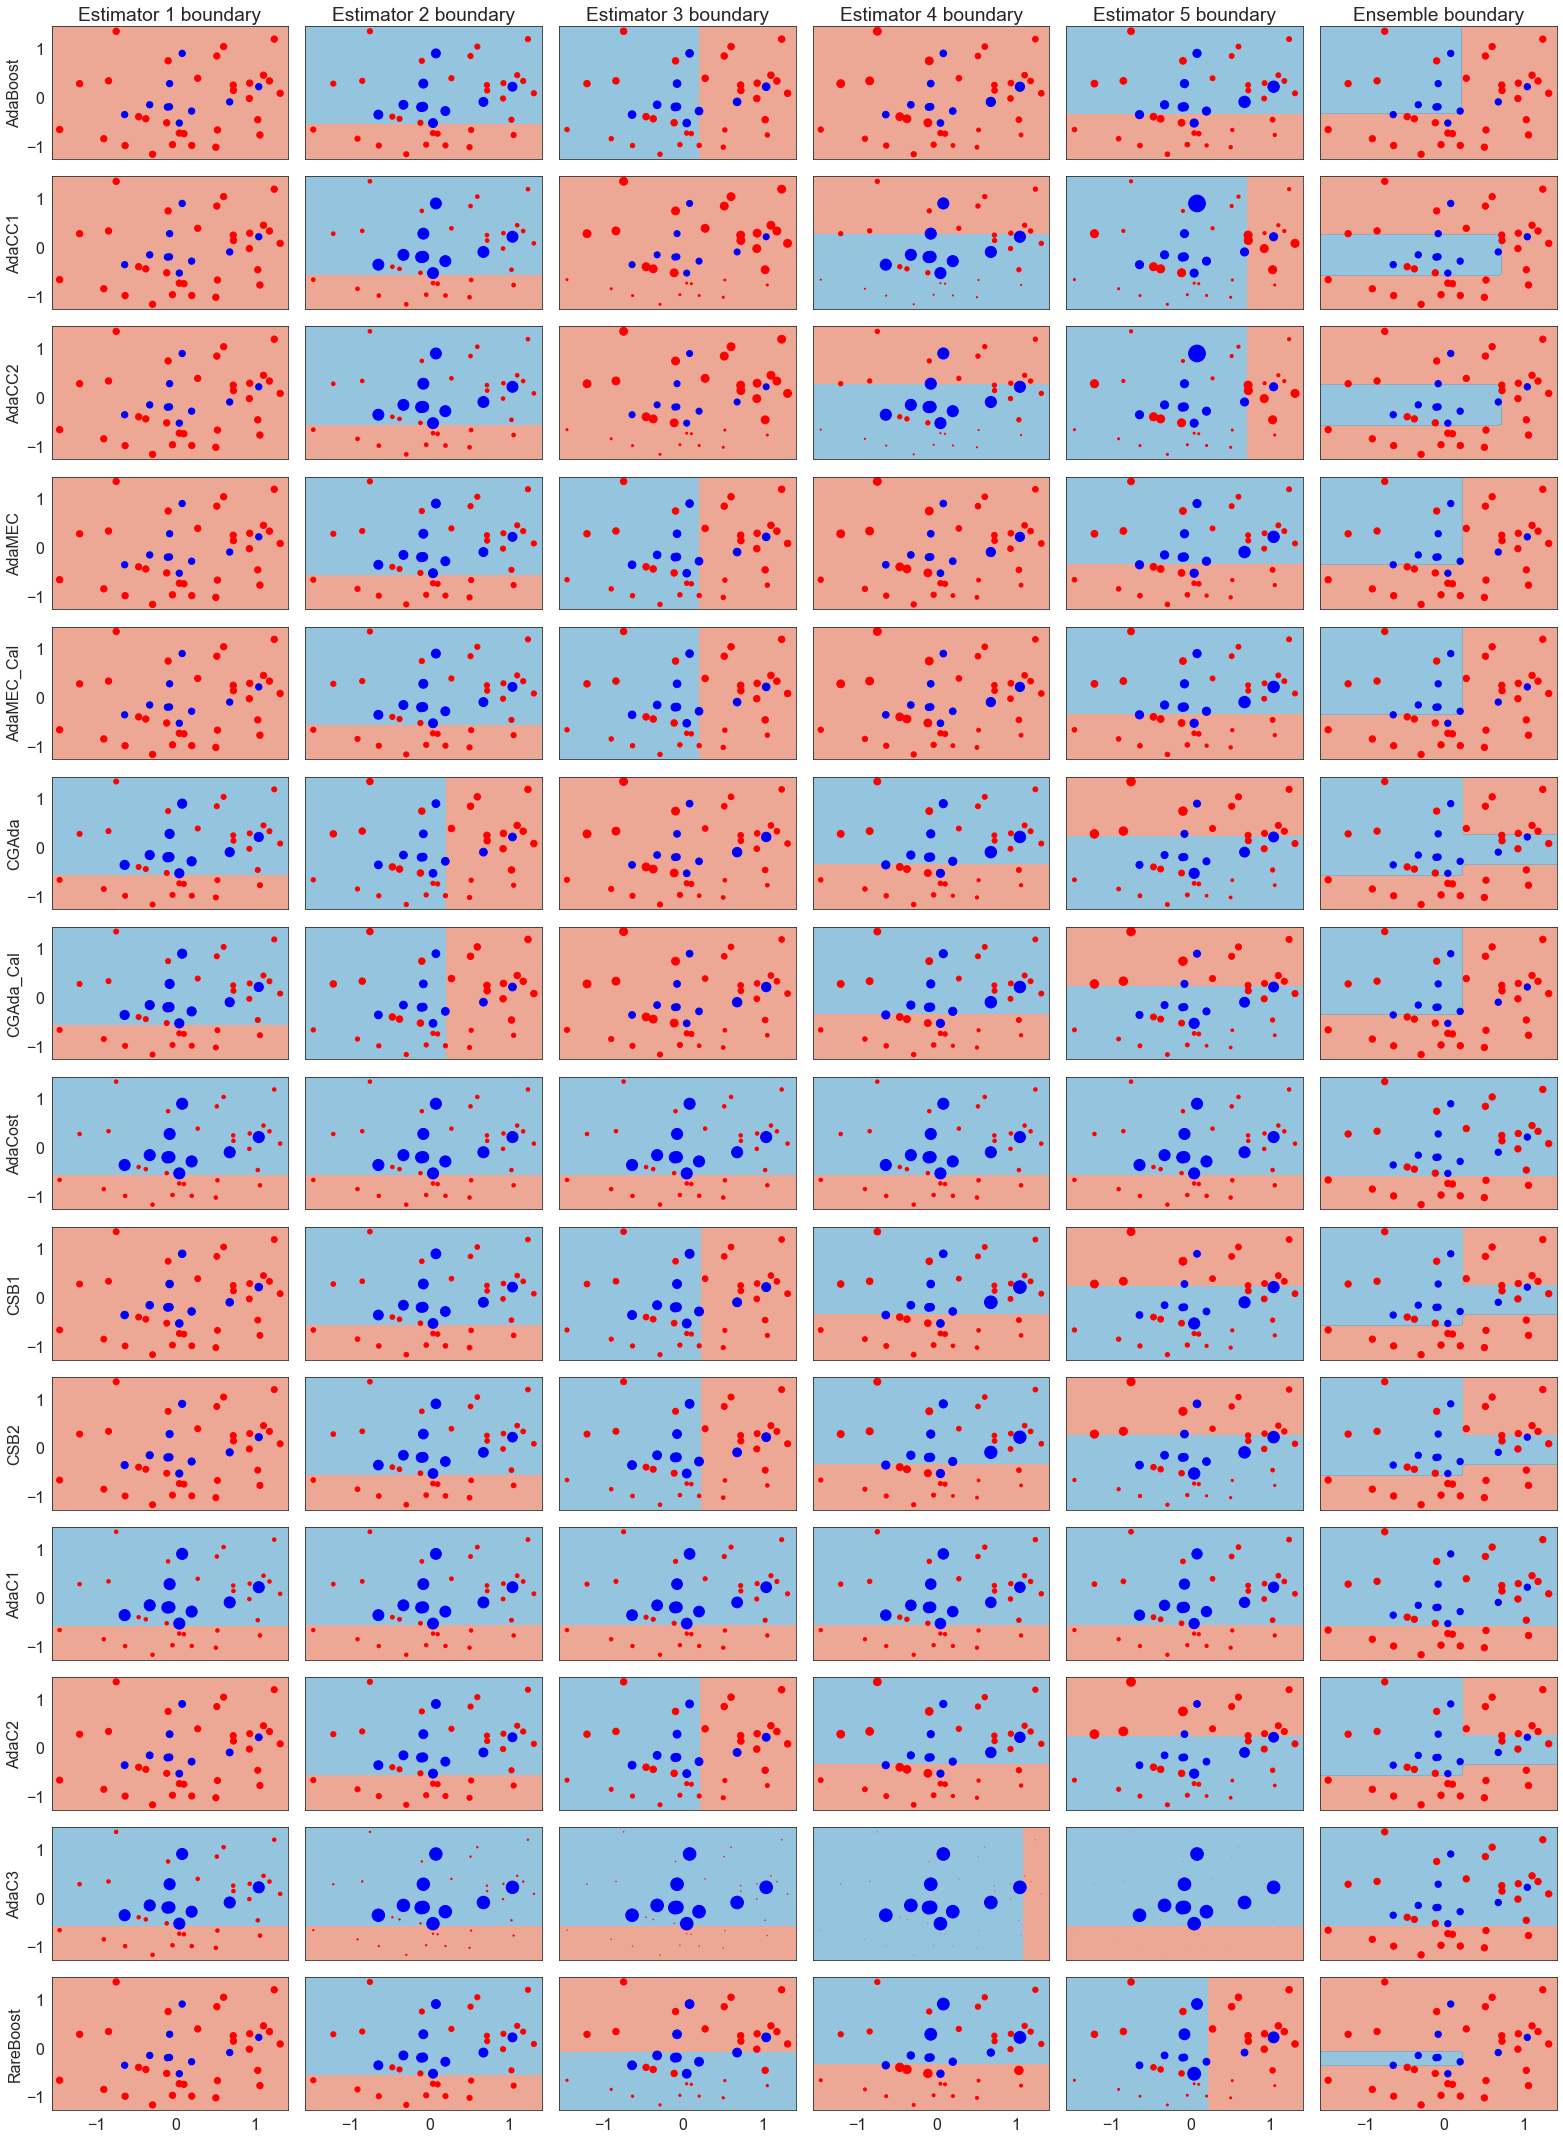

In [8]:
M =5
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

for loop in range (414,416):
    X, y = make_circles(n_samples = 200, noise=0.3, factor=0.3,random_state=loop)
    X, y = make_imbalance(X, y, sampling_strategy={0: 30, 1: 10},random_state=0)
    
    
    list_of_methods = ['AdaBoost', 'AdaCC1', 'AdaCC2',  'AdaMEC', 'AdaMEC_Cal', 'CGAda',
                       'CGAda_Cal', 'AdaCost', 'CSB1',
                       'CSB2', 'AdaC1', 'AdaC2', 'AdaC3', 'RareBoost']
    
    temp_methods = list(list_of_methods)
    
    estimator_list = []
    sample_weight_list = []
    models = []
    scores = []
    for method in list_of_methods:
        if "AdaCC" in method:
            estimators_temp, _, sample_weight_temp, model  = AdaCC_scratch(X,y, M, 'AdaCC1')
        elif method == "AdaBoost":
            model = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), algorithm = 'SAMME',n_estimators=M, learning_rate=1.0)
            model.fit(X,y)
            estimators_temp, _, sample_weight_temp  = AdaBoost_scratch(X,y, M, learning_rate = 1)
        else:
            estimators_temp, sample_weight_temp, model  = competitors(X,y, M, method)

        scores.append(balanced_accuracy_score(y,model.predict(X)))

        if method != "AdaMEC" and method != "AdaMEC_Cal" and method != "CGAda_Cal":
            estimator_list.append(estimators_temp)
            sample_weight_list.append(sample_weight_temp)
        elif method == "AdaMEC" or method == "AdaMEC_Cal":
            estimator_list.append(estimator_list[0])
            sample_weight_list.append(sample_weight_list[0])
            
        elif method == "CGAda_Cal":
            estimator_list.append(estimator_list[5])
            sample_weight_list.append(sample_weight_list[5])
        models.append(model)
        
        
    zipped_list = zip(scores, temp_methods)
    sorted_pairs = sorted(zipped_list, reverse=True)

    if 'AdaCC' in sorted_pairs[0][1] and 'AdaCC' in  sorted_pairs[1][1]:
        go = True
        print (loop)
    else:
        go = False    
      
    if go:
        fig, axs = plt.subplots(len(list_of_methods), M+1, figsize = (22,30),  sharex='col', sharey='row')      
        for k in range(0, len(list_of_methods)):
            for m in range(0,M+1):
                if m != M:
                    s_weights = (sample_weight_list[k][m,:] / sample_weight_list[k][m,:].sum() ) * len(y)
                    plot_decision_boundary(estimator_list[k][m], X,y,N = 50,ax = axs[k,m], scatter_weights =s_weights )
                    if k == 0:
                        axs[k,m].set_title('Estimator {} boundary'.format(m+1))
                else:
                    axs[k,0].set_ylabel(list_of_methods[k])
                    s_weights = (sample_weight_list[k][0,:] / sample_weight_list[k][0,:].sum() ) * len(y)
                    flag =True
                    flag2 = False
                    if list_of_methods[k] == "AdaBoost":
                        flag = False
                    
                    if "AdaMEC" in list_of_methods[k] or "Cal" in list_of_methods[k] :
                        flag2 = True
                    
                    print(list_of_methods[k])
                    plot_decision_boundary(models[k], X,y,N = 50, ax = axs[k,m], flag=flag, second=flag2)
                    if k == 0:
                        axs[k,m].set_title('Ensemble boundary')

            plt.tight_layout()

        plt.savefig("Images/Boundaries/overall" + str(loop) + ".png", bbox_inches='tight', dpi=100)
        